<a href="https://colab.research.google.com/github/bborisggg/hw_econometrics/blob/main/hw_econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!rm -rf hw_econometrics

In [44]:
!git clone https://github.com/bborisggg/hw_econometrics

Cloning into 'hw_econometrics'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 213.61 KiB | 6.89 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [45]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [46]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries, maxlag='auto', regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Опираемся на одну из возможных спецификаций модели:

https://doi.org/10.1108/IJOEM-10-2018-0551

Берем из статьи набор переменных

$$X_t = (\Delta oilp_t ; ygap_t ; \Delta ms_t ; \Delta ir_t ; \Delta er_t; \Delta cpi_t)'$$

Отсюда берем данные по цене на нефть марки Brent
https://fred.stlouisfed.org/series/MCOILBRENTEU

<Axes: xlabel='date'>

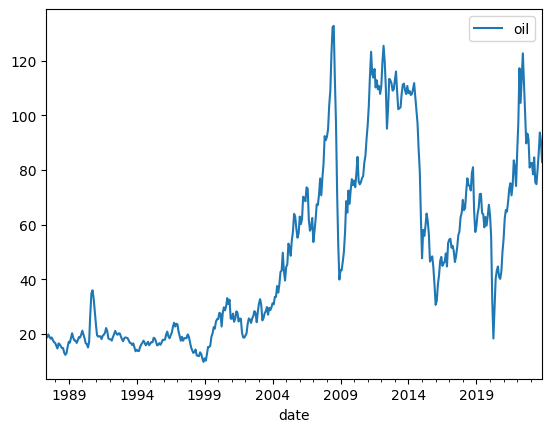

In [47]:
oil = pd.read_excel('hw_econometrics/data/MCOILBRENTEU.xls',skiprows=10)
oil = oil.rename(columns={'observation_date':'date','MCOILBRENTEU':'oil'})
oil = oil.set_index('date')
oil.index = pd.PeriodIndex(oil.index, freq='M')
oil.plot()

<Axes: xlabel='date'>

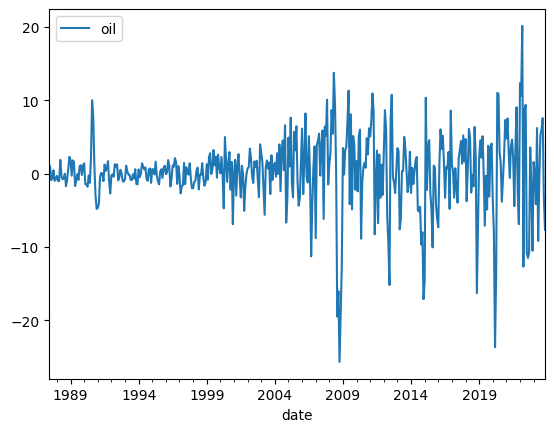

In [48]:
d_oil = oil.diff().iloc[1:]
d_oil.plot()

In [49]:
adf_test(d_oil, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.490933e+01
p-value                        1.466550e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


In [50]:
kpss_test(d_oil, maxlag='auto', regression='c')

Results of KPSS Test:
Test Statistic           0.031762
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-46-5a7a53ad64c0>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)


Можем считать, что ряд стационарен

Ряд разрыва выпуска можем получить из данных по индексу промышленного производства Росстата
Источник:
https://fedstat.ru/indicator/43046
https://fedstat.ru/indicator/57806

<Axes: xlabel='date'>

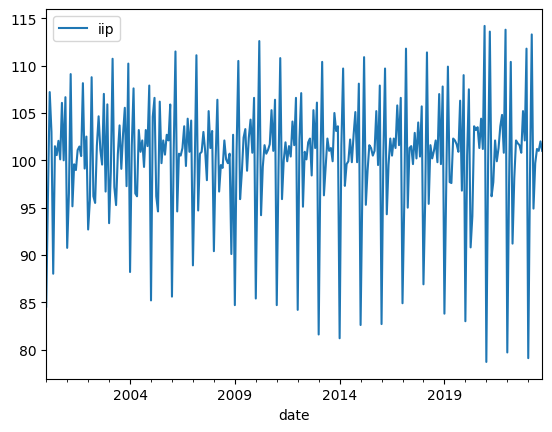

In [56]:
iip = pd.read_excel('hw_econometrics/data/iip_russia.xlsx')
iip = iip.set_index('date')
iip.index = pd.PeriodIndex(iip.index, freq='M')
iip.plot()

У нас есть цепной индекс изменений. Хотим перейти к базисному индексу

In [57]:
iip = (iip/100).cumprod()

In [59]:
iip.index = iip.index.strftime('%Y-%m-%d')

In [ ]:
iip.to_excel('iip_unadjusted.xlsx')